In [ ]:

# loading important modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import itertools


In [ ]:
# Reading the dataset
data = pd.read_csv("/Users/sriramsasank/Documents/Python/SalesKaggle3.csv")

In [ ]:
def ABC_segmentation(perc):
    '''
    Creates the 3 classes A, B, and C based 
    on quantity percentages (A-60%, B-25%, C-15%)
    '''
    if perc > 0 and perc < 0.6:
        return 'A'
    elif perc >= 0.6 and perc < 0.85:
        return 'B'
    elif perc >= 0.85:
        return 'C'

In [ ]:
# take a subset of the data, we need to use the price and the quantity of each item
data_sub = data[['SKU_number','PriceReg','ItemCount','File_Type']][(data['File_Type'] == 'Historical')]
# create the column of the additive cost per SKU
data_sub['AddCost'] = data_sub['PriceReg'] * data_sub['ItemCount']
# order by cumulative cost
data_sub = data_sub.sort_values(by=['AddCost'], ascending=False)
# create the column of the running CumCost of the cumulative cost per SKU
data_sub['RunCumCost'] = data_sub['AddCost'].cumsum()
# create the column of the total sum
data_sub['TotSum'] = data_sub['AddCost'].sum()
# create the column of the running percentage
data_sub['RunPerc'] =  data_sub['RunCumCost']/data_sub['TotSum']
# create the column of the class
data_sub['Class'] = data_sub['RunPerc'].apply(ABC_segmentation)

In [ ]:
# total cost per class
print ('Cost of Class A :', data_sub[data_sub.Class == 'A']['AddCost'].sum())
print ('Cost of Class B :', data_sub[data_sub.Class == 'B']['AddCost'].sum())
print ('Cost of Class C :', data_sub[data_sub.Class == 'C']['AddCost'].sum())

In [ ]:
# percent of total cost per class
print ('Percent of Cost of Class A :', data_sub[data_sub.Class == 'A']['AddCost'].sum()/data_sub['AddCost'].sum())
print ('Percent of Cost of Class B :', data_sub[data_sub.Class == 'B']['AddCost'].sum()/data_sub['AddCost'].sum())
print ('Percent of Cost of Class C :', data_sub[data_sub.Class == 'C']['AddCost'].sum()/data_sub['AddCost'].sum())

In [ ]:
performance = data_sub['AddCost'].tolist()
y_pos = np.arange(len(performance))

plt.plot(y_pos, performance)
plt.ylabel('Cost')
plt.title('ABC Analysis - Cost per SKU')
plt.grid(True)
plt.ylim((0,250000))
plt.show()

In [ ]:
performance = data_sub['RunPerc'].tolist()
y_pos = np.arange(len(performance))

plt.plot(y_pos, performance)
plt.ylabel('Running Total Percentage')
plt.title('ABC Analysis - Cumulative Cost per SKU')
plt.grid(True)
plt.show()

In [ ]:
# Gist of the dataset
data.head()

In [ ]:
# Basic questions about the dataset

# 1. Number of enteries 
print(data.shape)
# We have 198917 rows and 14 columns 

# 2. Total number of products & unique values of the columns 
print("*****************")
print(data.nunique())

# 3. Count of the historical and active state 
print("*****************")
print(data[data['File_Type'] == 'Historical']['SKU_number'].count())
print(data[data['File_Type'] == 'Active']['SKU_number'].count())

# 3.1 Split the dataset into two parts based on the file_type 
sales_data_hist = data[data['File_Type'] == 'Historical']
sales_data_act = data[data['File_Type'] == 'Active']


### Univariate outlier detection 

To analysis the outliers in the numeric features of the dataset 

In [ ]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
        
    sns.boxplot(y=sales_data_hist[col_val], ax=ax[i])
    ax[i].set_title('Box plot - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

### Correlation plot

Positively correlated variables will have correlation value close to +1 and negatively correlated variables will have correlation value close to -1.

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = sales_data_hist.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Univariate Outlier treatment

Many algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the results and make results less reliable, that's why we have to recognize all the outliers and treat them.

In [ ]:
# Percentile based outlier removal 
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = sales_data_hist[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

## Predictive Modelling

The classification module predicts the SKU which needs to kept in the inventory (Active state) 

In [ ]:
# Converting maarketing type to categorical variable 
data['MarketingType'] = data['MarketingType'].astype('category')
data['MarketingType'] = data['MarketingType'].cat.codes

# Splitting the historical and active state
sales_data_hist = data[data['File_Type'] == 'Historical']
sales_data_act = data[data['File_Type'] == 'Active']

In [ ]:
# Columns to remove 
remove_col_val = ['Order', 'File_Type', 'SKU_number', 'SoldCount', 'ReleaseNumber', 'SoldFlag']

y = sales_data_hist['SoldFlag']

sales_data_hist = sales_data_hist.drop(remove_col_val, axis=1)
sales_data_act = sales_data_act.drop(remove_col_val, axis=1)

# create training and testing vars
training_features, testing_features, training_target, testing_target = train_test_split(sales_data_hist, y, test_size=0.2)
print(training_features.shape, training_target.shape)
print(testing_features.shape, testing_target.shape)

In [ ]:
print("Class 0 numbers: " , len(training_target[training_target==0.0]))
print("Class 1 numbers: " , len(training_target[training_target==1.0]))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)

In [ ]:
# Balancing the classes using SMOTE
sm = SMOTE(random_state=12, sampling_strategy= 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

print("Class 0 numbers: " , len(y_train_res[y_train_res==0.0]))
print("Class 1 numbers: " , len(y_train_res[y_train_res==1.0]))

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

In [63]:
print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))

pred = clf_rf.predict(testing_features)

print('\nTest Results')
print(clf_rf.score(testing_features, testing_target))
print(recall_score(testing_target, pred))

print('\nROC AUC score')
print(roc_auc_score(testing_target, pred))
print(testing_target,pred)
print('\n')

Validation Results
0.7421052631578947
0.539282250242483

Test Results
0.7465131578947368
0.5505661850839516

ROC AUC score
0.6683917245540021
40131    0.0
36969    0.0
8197     0.0
22887    0.0
15572    1.0
        ... 
10793    0.0
29469    0.0
51520    0.0
7081     0.0
34650    0.0
Name: SoldFlag, Length: 15200, dtype: float64 [0. 0. 0. ... 0. 1. 1.]


       MarketingType  New_Release_Flag  StrengthFactor  PriceReg  ReleaseYear  \
40131              1                 1       2423677.0     93.96         2006   
36969              1                 1       1403764.0     66.95         1995   
8197               0                 1       1662231.0    143.00         2002   
22887              0                 1        551437.0     49.31         2007   
15572              0                 1        259596.0    120.00         2009   
...              ...               ...             ...       ...          ...   
10793              0                 1       1177530.0    166.67         200

### Confusion Matrix

Confusion matrix, without normalization
[[9937 2702]
 [1151 1410]]
Normalized confusion matrix
[[0.79 0.21]
 [0.45 0.55]]


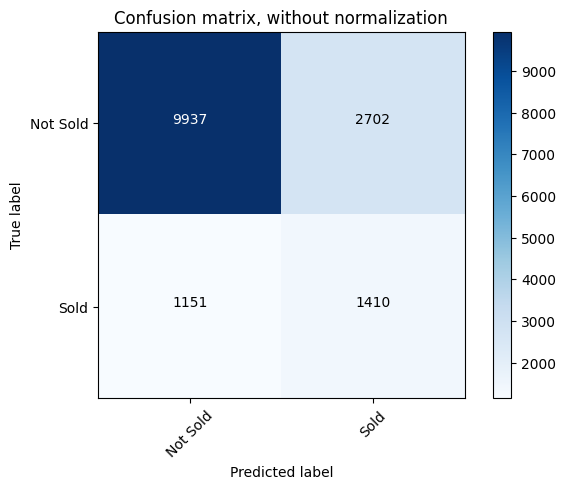

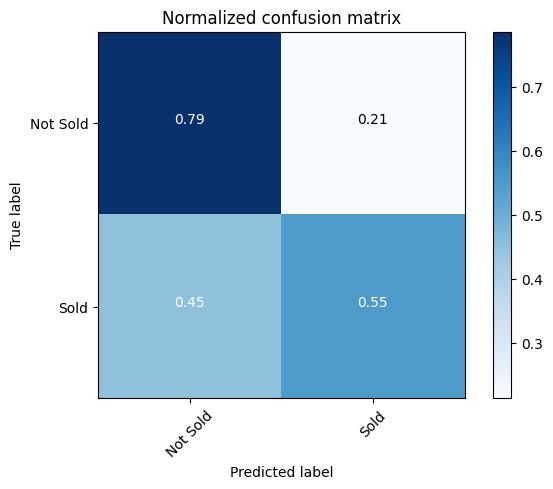

In [59]:
class_names = ['Not Sold', 'Sold']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(testing_target, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ROC

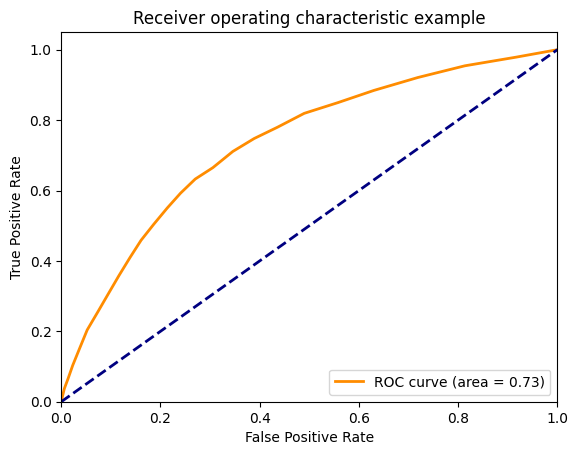

In [60]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
y_score = clf_rf.predict_proba(testing_features)

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testing_target.ravel(), y_score[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['micro'])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
